## Importing Common Libs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import torch 
import json
import sys
import torch
import torch.nn.functional as F
import os
import numpy as np

sys.path.append("src")
os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_paper')

from data_class import SongDataSet_Image, CollateFunction
from model import TweetyBERT
from analysis import plot_umap_projection
from utils import detailed_count_parameters, load_weights, load_model

/home/george-vengrovski/anaconda3/envs/canary-vae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.data import DataLoader
from data_class import SongDataSet_Image

train_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb3_train"
test_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb3_test"

train_dataset = SongDataSet_Image(train_dir, num_classes=21, psuedo_labels_generated=False)
test_dataset = SongDataSet_Image(test_dir, num_classes=21, psuedo_labels_generated=False)

collate_fn = CollateFunction(segment_length=1000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

## UMAP 

In [ ]:
reductions_dims = 2
plot_figure = True 

import pickle 
import umap

list_of_data = []
list_of_ground_truth = []

for i,  (data, ground_truth_label, _) in enumerate(train_loader):
    # remove channel dim (used for conv)
    data = data[:,0,:,:]
    data = data.permute(0,2,1)
    ground_truth_label = ground_truth_label.argmax(-1)
    data = data.cpu().numpy()
    ground_truth_label = ground_truth_label.cpu().numpy()
    ground_truth_label = ground_truth_label.reshape(-1,1)
    data = data.reshape(-1,1 * 196)
    list_of_data.append(data)
    list_of_ground_truth.append(ground_truth_label)

    if i > 100:
        break

# Concatenate the lists
list_of_data = np.concatenate(list_of_data, axis=0)
list_of_ground_truth = np.concatenate(list_of_ground_truth, axis=0)

# Randomly sample 10,000 points
sample_indices = np.random.choice(list_of_data.shape[0], 10000, replace=False)
list_of_data_sampled = list_of_data[sample_indices]
list_of_ground_truth_sampled = list_of_ground_truth[sample_indices]


# color stuff #
file_path = "/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/category_colors_llb3.pkl"
with open(file_path, 'rb') as file:
    color_map_data = pickle.load(file)

label_to_color = {label: tuple(color) for label, color in color_map_data.items()}

colors_for_points = []
for label_row in list_of_ground_truth_sampled:
    if label_row.ndim > 0:
        # If label_row is iterable (more than one dimension)
        row_colors = [label_to_color[int(lbl)] for lbl in label_row]
        avg_color = np.mean(row_colors, axis=0)
    else:
        # If label_row is a single integer (one dimension)
        avg_color = label_to_color[int(label_row)]
    colors_for_points.append(avg_color)


# UMAP reduction
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.05, n_components=reductions_dims, metric='euclidean')
embedding_outputs = reducer.fit_transform(list_of_data_sampled)

# Plotting (if conditions are met)
if reductions_dims == 2 and plot_figure == True:
    # Create the plot
    fig = plt.figure(figsize=(8, 6))
    plt.scatter(embedding_outputs[:, 0], embedding_outputs[:, 1], s=5, c=colors_for_points)
    plt.title('UMAP projection of the Spectograms', fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_model = LinearProbeModel(num_classes=21, model_type="umap", model=reducer, freeze_layers=True, layer_num=-1, layer_id="feed_forward_output_relu", classifier_dims=2)
classifier_model = classifier_model.to(device)


In [ ]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-3, plotting=True, batches_per_eval=1, desired_total_batches=5, patience=8)
trainer.train()

In [ ]:
from linear_probe import ModelEvaluator

evaluator = ModelEvaluator(classifier_model, test_loader)
class_frame_error_rates, total_frame_error_rate = evaluator.validate_model_multiple_passes(num_passes=1, max_batches=1250)
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, 'results')

## PCA Plot Visual Inspection (Not needed for later steps)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle

reductions_dims = 2
plot_figure = True

list_of_data = []
list_of_ground_truth = []

for i, (data, ground_truth_label, _) in enumerate(test_loader):
    # Remove channel dimension (used for convolutional layers)
    data = data[:, 0, :, :]
    # Permute dimensions
    data = data.permute(0, 2, 1)
    # Convert labels to indices
    ground_truth_label = ground_truth_label.argmax(-1)
    # Convert to numpy arrays
    data = data.cpu().numpy()
    ground_truth_label = ground_truth_label.cpu().numpy()
    # Reshape labels
    ground_truth_label = ground_truth_label.reshape(-1, 1)
    data = data.reshape(-1, 1 * 196)
    # Append to lists
    list_of_data.append(data)
    list_of_ground_truth.append(ground_truth_label)

    # Break the loop after processing 101 batches
    if i > 100:
        break

# Concatenate the lists
list_of_data = np.concatenate(list_of_data, axis=0)
list_of_ground_truth = np.concatenate(list_of_ground_truth, axis=0)

# Randomly sample 10,000 points
sample_indices = np.random.choice(list_of_data.shape[0], 10000, replace=False)
list_of_data_sampled = list_of_data[sample_indices]
list_of_ground_truth_sampled = list_of_ground_truth[sample_indices]

# Load color map data
file_path = "/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/category_colors_llb3.pkl"
with open(file_path, 'rb') as file:
    color_map_data = pickle.load(file)

# Map labels to colors
label_to_color = {label: tuple(color) for label, color in color_map_data.items()}

# Prepare colors for plotting points
colors_for_points = []
for label_row in list_of_ground_truth_sampled:
    if label_row.ndim > 0:
        row_colors = [label_to_color[int(lbl)] for lbl in label_row]
        avg_color = np.mean(row_colors, axis=0)
    else:
        avg_color = label_to_color[int(label_row)]
    colors_for_points.append(avg_color)

# Initialize and apply PCA
pca = PCA(n_components=reductions_dims, random_state=42)
embedding_outputs = pca.fit_transform(list_of_data_sampled)

# Plot if conditions are met
if reductions_dims == 2 and plot_figure == True:
    fig = plt.figure(figsize=(8, 6))
    plt.scatter(embedding_outputs[:, 0], embedding_outputs[:, 1], s=5, c=colors_for_points)
    plt.title('PCA projection of the Spectograms', fontsize=14)
    plt.tight_layout()
    plt.show()


In [ ]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_model = LinearProbeModel(num_classes=21, model_type="pca", model=None, freeze_layers=None, layer_num=None, layer_id=None, classifier_dims=2)
classifier_model = classifier_model.to(device)

In [ ]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-3, plotting=True, batches_per_eval=100, desired_total_batches=1, patience=4)
trainer.train()

In [ ]:
from linear_probe import ModelEvaluator

evaluator = ModelEvaluator(classifier_model, test_loader, use_tqdm=True)
class_frame_error_rates, total_frame_error_rate = evaluator.validate_model_multiple_passes(num_passes=1, max_batches=1250)
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, 'results')

## Raw Spectogram

In [ ]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_model = LinearProbeModel(num_classes=21, model_type="raw", model=None, freeze_layers=None, layer_num=None, layer_id=None, classifier_dims=196)
classifier_model = classifier_model.to(device)

In [ ]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-3, plotting=True, batches_per_eval=100, desired_total_batches=1e4, patience=4)
trainer.train()

In [ ]:
from linear_probe import ModelEvaluator

evaluator = ModelEvaluator(classifier_model, test_loader, use_tqdm=True)
class_frame_error_rates, total_frame_error_rate = evaluator.validate_model_multiple_passes(num_passes=1, max_batches=1250)
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, 'results')

## SAP Factors

## AVES

In [3]:
import torchaudio
from torch import nn
import torch
import json
from torchaudio.models import wav2vec2_model

class AvesTorchaudioWrapper(nn.Module):
    def __init__(self, config_path, model_path):
        super().__init__()
        self.config = self.load_config(config_path)
        self.model = wav2vec2_model(**self.config, aux_num_out=None)
        self.model.load_state_dict(torch.load(model_path))
        self.model.feature_extractor.requires_grad_(False)

    def load_config(self, config_path):
        with open(config_path, 'r') as ff:
            obj = json.load(ff)
        return obj

    def forward(self, sig):
        out = self.model.extract_features(sig)[0][-1]
        return out

model_path = "/home/george-vengrovski/Documents/data/AVES Data/aves-base-all.torchaudio.pt"
config_path = "/home/george-vengrovski/Documents/data/AVES Data/aves-base-all.torchaudio.model_config.json"
test_song = "/home/george-vengrovski/Documents/data/llb3_data_wav/llb3_songs/llb3_0001_2018_04_23_14_18_03.wav"

torchaudio_model = AvesTorchaudioWrapper(config_path, model_path)
torchaudio_model.eval()

# Load test song audio waveform and downsample to 16000 Hz
waveform, sample_rate = torchaudio.load(test_song)
if sample_rate != 16000:
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
    waveform = resampler(waveform)

print(waveform.shape)
waveform = waveform[:,:16080]
print(waveform.shape)

# Forward pass through the model
output = torchaudio_model.forward(waveform)
print(output.shape)

torch.Size([1, 22708])
torch.Size([1, 16080])
torch.Size([1, 50, 768])


In [27]:
import pandas as pd

# Load the specified CSV file into a DataFrame
df = pd.read_csv('/home/george-vengrovski/Documents/data/llb3_data_wav/llb3_annot.csv')

sample_freq = 16100 

# Function to include the first onset and the last offset value for contiguous groups
def aggregate_onset_offset(df, filename, label, onset, offset):
    # Create a new column to identify contiguous groups
    df['group'] = (df[filename] != df[filename].shift(1)) | (df[label] != df[label].shift(1))
    df['group'] = df['group'].cumsum()

    # Aggregate the first onset and the last offset for each group
    aggregated_df = df.groupby(['group', filename, label], as_index=False).agg({onset: 'first', offset: 'last'})

    # Drop the group column from the aggregated dataframe
    aggregated_df = aggregated_df.drop(columns=['group'])

    return aggregated_df

# Aggregate and include the first onset and the last offset
aggregated_df_onset_offset = aggregate_onset_offset(df, 'audio_file', 'label', 'onset_s', 'offset_s')

# Add new columns for onset and offset multiplied by the sample frequency
aggregated_df_onset_offset['onset_sample'] = aggregated_df_onset_offset['onset_s'] * sample_freq
aggregated_df_onset_offset['offset_sample'] = aggregated_df_onset_offset['offset_s'] * sample_freq




In [28]:
downsample_factor = 320 

aggregated_df_onset_offset['onset_sample'] = (aggregated_df_onset_offset['onset_sample'] / downsample_factor).round()
aggregated_df_onset_offset['offset_sample'] = (aggregated_df_onset_offset['offset_sample'] / downsample_factor).round()


In [29]:

# Save the updated DataFrame to a CSV file
output_file_path_onset_offset = 'test.csv'
aggregated_df_onset_offset.to_csv(output_file_path_onset_offset, index=False)

In [30]:
import pandas as pd
# Assuming the DataFrame is already sorted by onset_sample
# Iterate through the DataFrame to find gaps
new_rows = []
for i in range(len(aggregated_df_onset_offset) - 1):
    current_offset = aggregated_df_onset_offset.iloc[i]['offset_sample']
    next_onset = aggregated_df_onset_offset.iloc[i + 1]['onset_sample']
    if next_onset - current_offset > 1:
        # Non-contiguous samples found, create a new row to fill the gap
        new_row = {
            'audio_file': aggregated_df_onset_offset.iloc[i]['audio_file'],  # Assuming the same audio_file
            'label': 0,
            'onset_s': None,  # These can be calculated if necessary
            'offset_s': None,  # These can be calculated if necessary
            'onset_sample': current_offset + 1,
            'offset_sample': next_onset - 1
        }
        new_rows.append(new_row)

# Convert the list of new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows)

# Append the new rows to the original DataFrame
df = aggregated_df_onset_offset.append(new_rows_df, ignore_index=True)

# Sort by onset_sample to maintain order
df = df.sort_values(by='onset_sample').reset_index(drop=True)


,audio_file,label,onset_s,offset_s,onset_sample,offset_sample
0,llb3_0002_2018_04_23_14_18_03.wav,18,0.035079,0.948345,2.0,48.0
1,llb3_0002_2018_04_23_14_18_03.wav,3,1.068073,13.627528,54.0,686.0
2,llb3_0002_2018_04_23_14_18_03.wav,8,13.663447,14.907619,687.0,750.0
3,llb3_0002_2018_04_23_14_18_03.wav,10,14.950522,16.017098,752.0,806.0
4,llb3_0002_2018_04_23_14_18_03.wav,1,16.167134,16.732857,813.0,842.0
...,...,...,...,...,...,...
16103,llb3_4311_2018_05_03_16_58_56.wav,3,11.101270,12.840317,559.0,646.0
16104,llb3_4311_2018_05_03_16_58_56.wav,6,12.938095,14.433696,651.0,726.0
16105,llb3_4314_2018_05_03_18_17_42.wav,16,0.222993,0.455465,11.0,23.0
16106,llb3_4314_2018_05_03_18_17_42.wav,6,0.709683,1.764762,36.0,89.0


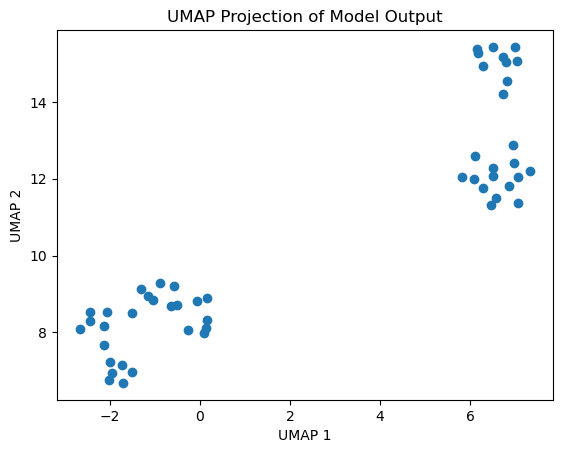

In [23]:
import umap

# Apply UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(output[0].detach().cpu().numpy())

# Plotting
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.title("UMAP Projection of Model Output")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()